# [E - 11] ARIMA
  
 __ADF-test의 p-value가 유의한 결과이거나, ACF Plot을 나타내본 후, ACF가 1시점 이후에 급격하게 낮아지는 지점이 있으면 stationary 하다고 생각할 수 있다.__
  * 1. 전처리 : 데이터를 stationary 상태로 들어준다.
 
     * 1) log 변환
     * 2) 차분 
     
     
  * 2. 시범 모델 생성 : ARIMA 모델의 q와 p를 달리하여 시범 모델을 생성한 후, AIC값을 비교하여 가장 낮은 AIC값을 가지는 모델을 채택한다.
  
  
  * 3. 모델 검증 : 모델의 residual(y_hat - y)값을 가지고 ACF Plot을 출력해 본 후, bound안에 대부분의 값들이 속해있는지 확인한다. 여기서 bound란 residual의 분산 * +-3 을 의미한다.
  
  
  * 4. Forecasting : 생성된 모델을 가지고 다음 시계열을 예측해본다.
     
  
    

## 1. 시계열 데이터 확인 및 전처리

In [48]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import Image

path = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
data = pd.read_csv(path, index_col='Date', parse_dates=True)
ts = data['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [49]:
#결측치 처리
ts = ts.interpolate(method='time') #결측치가 있으면 시간기준 보간법사용
ts[ts.isna()] #결측치 확인

Series([], Name: Close, dtype: float64)

### (1) 주가 데이터 시각화

In [50]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
 
    plt.legend(loc='best')
    plt.title('Original & Rolling Mean ')
    plt.show(block=False)
    



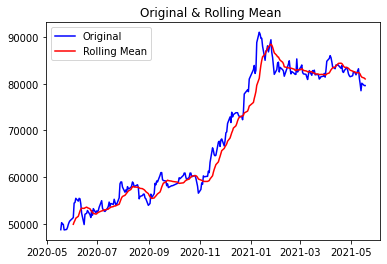

In [51]:
plot_rolling_statistics(ts)

그래프로 확인해보면, 아직 stationary하지 않음을 확인할 수 있다.

### (2) ADF-Test를 이용하여 정량적으로 data가 stationary한지 확인

In [52]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    


In [53]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


p-value의 값이 0.66으로 귀무가설(데이터가 non-stationary하다)를 기각할 수 없다.

### (3) ACF와 PACF 출력

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_ACF_PACF(timeseries):
    plot_acf(timeseries)
    plot_pacf(timeseries)
    plt.show()

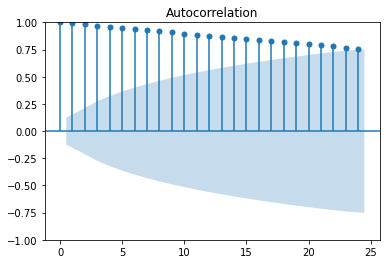

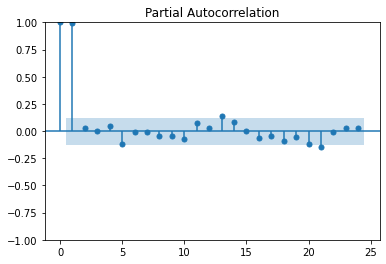

In [55]:
plot_ACF_PACF(ts)

ACF 값이 확 떨어진다면 stationary, 서서히 떨어진다면 non-stationary하다. 
출력된 ACF는 서서히 떨어지기 때문에 non-stationary함을 알 수 있다.

### (4) 시계열 안정성 분석

__위에서 시계열의 안정성을 체크했던__
* 1. 데이터 시각화, 
* 2. ADF-Test 
*     3. ACF,PACF Plot

__을 이용하여 시계열의 안정성을 분석하는 함수를 만들어보자.__

In [56]:
def timeseries_is_stationary(timeseries):
    # 데이터 시각화
    plot_rolling_statistics(timeseries, window=12)
    
    #ADF-Test
    augmented_dickey_fuller_test(timeseries)
    
    #ACF, PACF Plot
    plot_ACF_PACF(timeseries)
    
    
    

### (4) - 1 . log 변환 데이터
log변환시킨 데이터의 안정성을 확인해보자.

In [57]:
# 로그 변환
ts_log = np.log(ts)

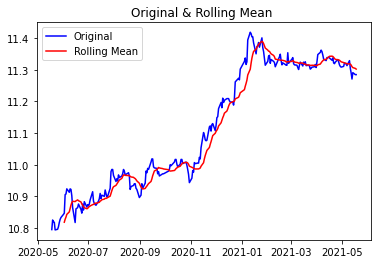

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


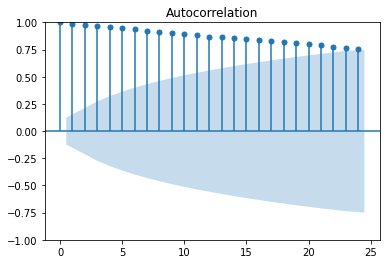

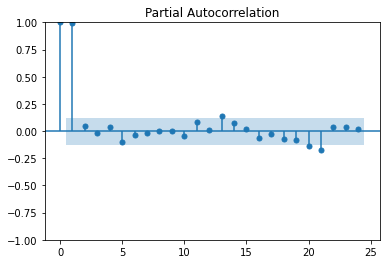

In [58]:
timeseries_is_stationary(ts_log)

p-value도 매우 높고, ACF도 서서히 감소하기 때문에 non-stationary하다. 
이번에는 차분한 데이터의 안정성을 확인해보자.

### (4) - 2. 1차 차분 데이터

In [59]:
#1차 차분
diff_1 = ts.diff(periods=1).iloc[1:]
diff_1 = diff_1.dropna()


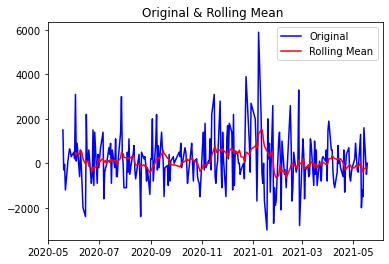

Results of Dickey-Fuller Test:
Test Statistic                -1.541059e+01
p-value                        3.127307e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


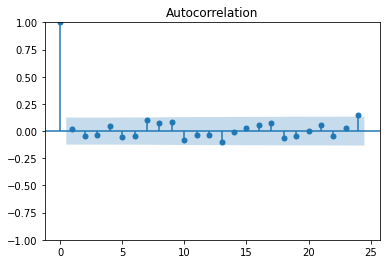

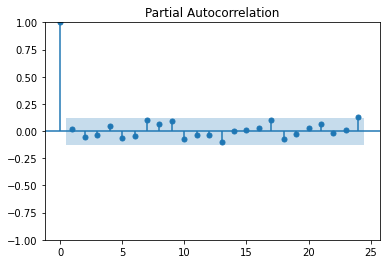

In [60]:
timeseries_is_stationary(diff_1)

__1차 차분한 값은 p-value값도 매우 낮고, ACF도 패턴 없이 급격하게 감소하기 때문에 stationary하다고 할 수 있다.__

### (4)-2. log변환 + 1차 차분 데이터

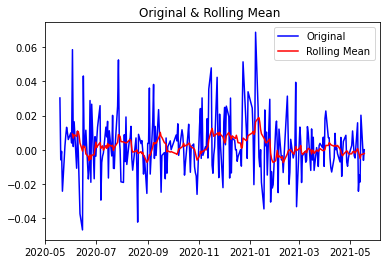

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


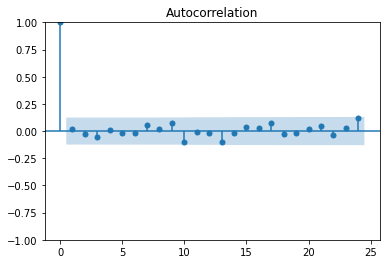

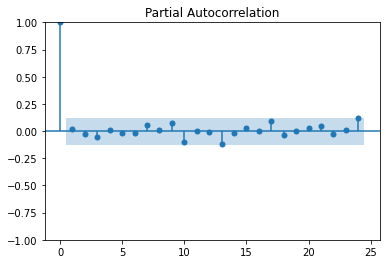

In [61]:
log_diff_1 = ts_log.diff(periods=1).iloc[1:]
log_diff_1 = log_diff_1.dropna()

timeseries_is_stationary(log_diff_1)

__log변환 + 1차 차분한 값은 p-value값도 매우 낮고, ACF도 패턴 없이 급격하게 감소하기 때문에 stationary하다고 할 수 있다.__

__p-value가 가장 낮은 결과가 나왔기 때문에 앞으로의 분석에서 이 데이터를 사용해보자__

### (5) 시계열 분해
방금 구한 1차차 분한 시계열을 분해를 통해 시각화 해보자.

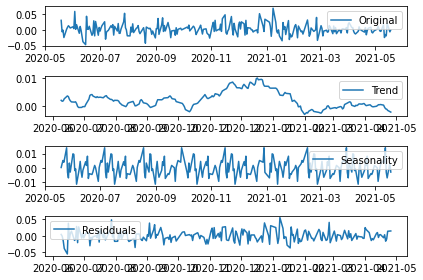

In [62]:

#시계열 분해
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(log_diff_1,period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(log_diff_1, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residduals')
plt.legend(loc='best')
plt.tight_layout()



## 4. 학습, 테스트 데이터셋 생성

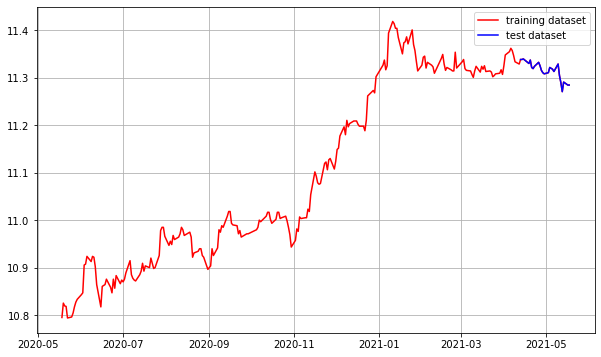

In [63]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)


#train_data 를 출력해야 하지만, 끊겨서 보이는걸 방지하기 위해 ts_log를 출력
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label = 'test dataset')
plt.legend()

## 2. 시범 모델 생성

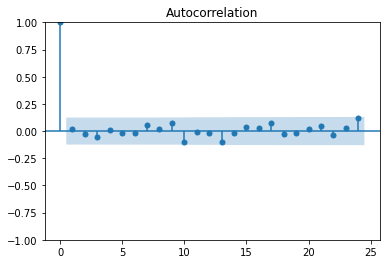

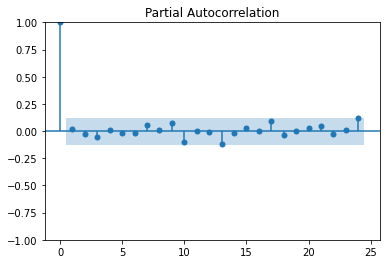

In [64]:
# ACF, PACF 그려보기 -> p,q 구하기
plot_ACF_PACF(log_diff_1)

pacf에서 lag 0이후에 0에 근접하므로 p는 0로 설정할 수 있고, 
acf에서도 lag 0이후에  0에 근접하기 때문에 q는 0으로 설정해보자

### estimate parameters

In [65]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(0,1,0))  #p,d,q
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 583.363
Date:                Thu, 17 Feb 2022   AIC                          -1164.726
Time:                        11:28:43   BIC                          -1161.314
Sample:                             0   HQIC                         -1163.349
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   2.33e-05     13.751      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                22.25
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.52
Prob(H) (two-sided):                  0.89   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 반복문을 통해 p, d, q의 범위를 달리 하면서 모델의 AIC값을 비교해보자

In [66]:
# Parameter search
from itertools import product #조합 생성

p = range(0,4)
d = range(1,3)
q = range(0,4)
pdq = list(product(p,d,q))

aic = []
for i in pdq:
    model = ARIMA(train_data.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA: {i} > AIC: {model_fit.aic}')
    aic.append(model_fit.aic)

ARIMA: (0, 1, 0) > AIC: -1164.7257702911484
ARIMA: (0, 1, 1) > AIC: -1162.9802059644367
ARIMA: (0, 1, 2) > AIC: -1160.9941949440877
ARIMA: (0, 1, 3) > AIC: -1159.2167755482544
ARIMA: (0, 2, 0) > AIC: -1013.0122942673136
ARIMA: (0, 2, 1) > AIC: -1155.0931767685079
ARIMA: (0, 2, 2) > AIC: -1153.078722441217
ARIMA: (0, 2, 3) > AIC: -1151.302190984793
ARIMA: (1, 1, 0) > AIC: -1162.9762232496196
ARIMA: (1, 1, 1) > AIC: -1160.9785390372508
ARIMA: (1, 1, 2) > AIC: -1158.98101288458
ARIMA: (1, 1, 3) > AIC: -1156.9947521494787
ARIMA: (1, 2, 0) > AIC: -1067.938002026895
ARIMA: (1, 2, 1) > AIC: -1153.19345790222
ARIMA: (1, 2, 2) > AIC: -1150.9382632381526
ARIMA: (1, 2, 3) > AIC: -1150.318840187345
ARIMA: (2, 1, 0) > AIC: -1161.0027224646985
ARIMA: (2, 1, 1) > AIC: -1159.0015993624625
ARIMA: (2, 1, 2) > AIC: -1157.2132462663824
ARIMA: (2, 1, 3) > AIC: -1155.252717064041
ARIMA: (2, 2, 0) > AIC: -1088.0002402622656
ARIMA: (2, 2, 1) > AIC: -1151.323111036148
ARIMA: (2, 2, 2) > AIC: -1149.723869281635

In [67]:
optimal = [(pdq[i],j)for i, j in enumerate(aic) if j == min(aic)]
optimal

[((0, 1, 0), -1164.7257702911484)]

__파이썬의 auto_arima 패키지를 이용하면 위의 반복문을 조금 더 쉽게 구현할 수 있다.__

In [68]:
from pmdarima.arima import auto_arima
model = auto_arima(train_data        # 데이터
                      , d = 1            # 차분 차수
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3   
                      , m = 1       
                      , seasonal = False 
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1166.730, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1164.792, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1164.794, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1164.726, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1162.816, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.220 seconds


#### optimal parameter로 최적 ARIMA모델을 만들어보자

In [69]:
model_opt = ARIMA(train_data.values, order=optimal[0][0])
model_opt_fit = model_opt.fit()

In [70]:
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  225
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 583.363
Date:                Thu, 17 Feb 2022   AIC                          -1164.726
Time:                        11:28:52   BIC                          -1161.314
Sample:                             0   HQIC                         -1163.349
                                - 225                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   2.33e-05     13.751      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                22.25
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.52
Prob(H) (two-sided):                  0.89   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

__우리 모델은 Plot을 찍어본 결과와 AIC를 비교해본 결과 모두 ARIMA(0,1,0)이 적합하다는걸 알 수 있다.__

## 3 . ARIMA 모델 검증

__만들어진 ARIMA모델은 우리가 예측한 데이터(y_hat)에서 실제 값(y)를 뺀 차이(residual)의 ACF plot을 그려봐서 검증할 수 있다.__


__생성된 ACF Plot의 3sigma 범위안에 값들이 대부분 들어가는지 확인해보자.__

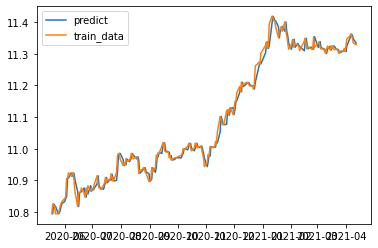

In [71]:
model_opt = ARIMA(train_data, order=optimal[0][0])
model_opt_fit = model_opt.fit()
model_predict = model_opt_fit.predict()
model_predict = model_predict.drop(model_predict.index[0])
plt.plot(model_predict, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

__먼저, 실제 시계열과 ARIMA모델로 훈련시킨 데이터를 출력해봤더니, 어느정도 일치하는것을 확인할 수 있었다.__

__이번에는 잔차 검정을 실시해보자. 잔차 검정은 파이썬의 plot_diagnostics()로 확인할 수 있다.__


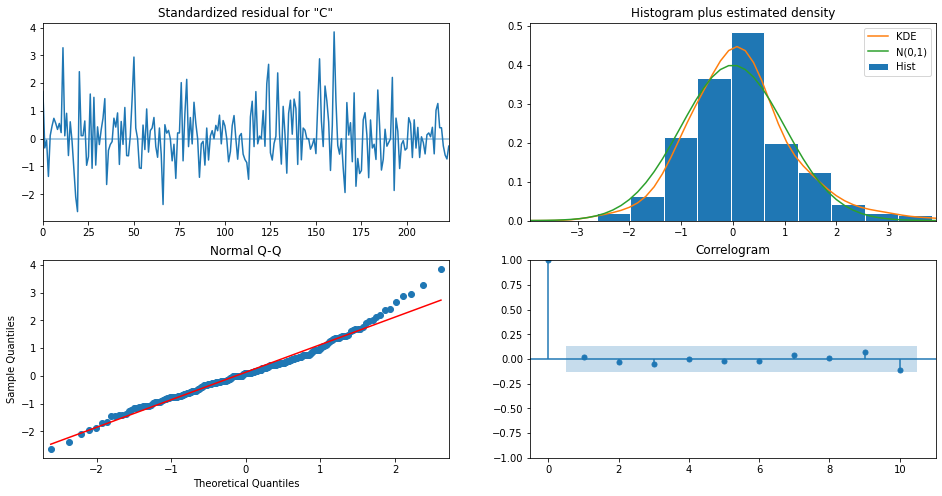

In [72]:
model_opt_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

__여기서 확인해봐야 할것은 Correlogram 이다. 이 그림에서 잔차가 0 이후에 일정 범위 안에 모두 들어와 있으므로, 시계열 모델이 잘 적합되었음을 알 수 있다.__

__또한 잔차가 정규성을 따른다면, Normal Q-Q Plot에서 빨간 선 위에 점들이 찍혀있어야 하는데, 그렇지 않으므로 우리의 데이터는 잘 적합되었지만, 잔차가 정규성을 띄지는 않는다고 볼 수 있다.__

## 4. 시계열 예측

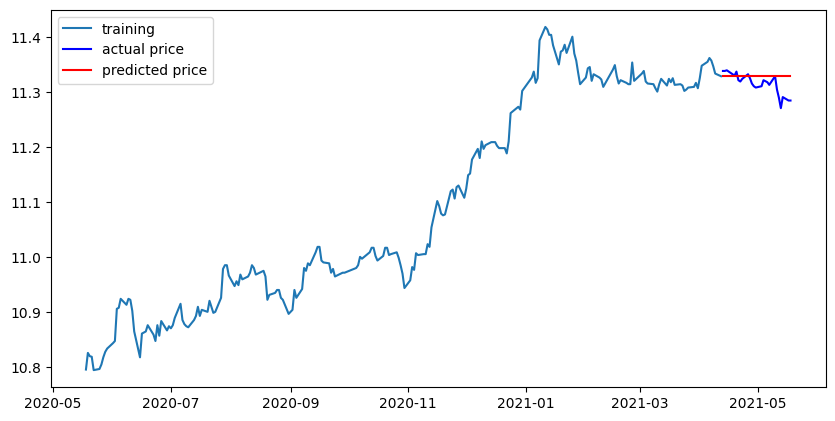

In [73]:
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc = np.array(fc)
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과


# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


* 우리가 만든 모델로 예측치를 확인해보니, 결과가 일직선으로 나오는 빨간색 그래프를 확인할 수 있었다.
* 그렇다면, 왜 결과가 일직선으로 나오게 되는걸까?
* 바로 우리가 만든 ARIMA(0,1,0)모델이 상수항이 없는 '임의보행 모델' 이기 때문이다. 


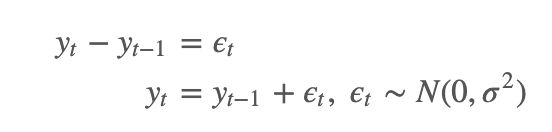

In [74]:

path = os.getenv('HOME') + '/aiffel/exploration/time.png'
Image(path)

* 예측을 할 때 innovation term인 ϵt의 기댓값이 0이기 때문에 이 부분을 0으로 대체하게 된다.
* 그렇기 때문에,예측치들은 결국 가장 마지막 관측치가 되는 것이다. 따라서 t가 증가해도 예측치가 모두 동일한 결과가 발생한다.

* 그럼 왜 auto_arima가 왜 임의 보행 모형을 가장 적합한 모델로 선택했을까?

* 데이터에 특정한 주기나 추세가 없기 때문에, AIC로 모형을 최적화를 하는 과정에서 의미있는 자기 상관 (AR)이나 이동 평균 (MA)를 찾기 어려웠기 때문이다.

## 5. 모델 평가

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3509600.000000066
MAE:  1408.0000000000023
RMSE:  1873.3926443754567
MAPE: 1.74%


## 6. 다른 종목에도 적용

### (1) 티커명: ETSY (1년간 일일 종가)

In [76]:
# 전처리 
path = os.getenv('HOME') + '/aiffel/exploration/ETSY.csv'
data = pd.read_csv(path, index_col='Date', parse_dates=True)
ts = data['Close']

ts.head()

Date
2021-02-17    222.410004
2021-02-18    220.820007
2021-02-19    227.270004
2021-02-22    213.119995
2021-02-23    210.750000
Name: Close, dtype: float64

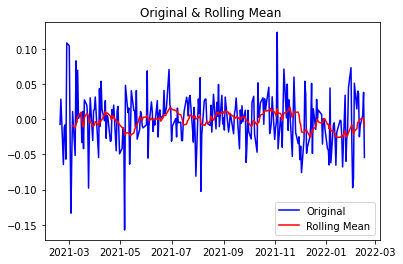

Results of Dickey-Fuller Test:
Test Statistic                -8.242627e+00
p-value                        5.663250e-13
#Lags Used                     3.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


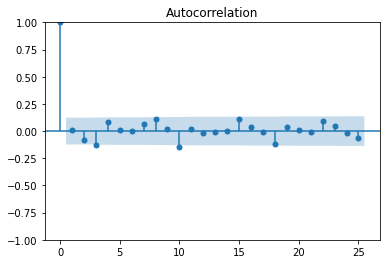

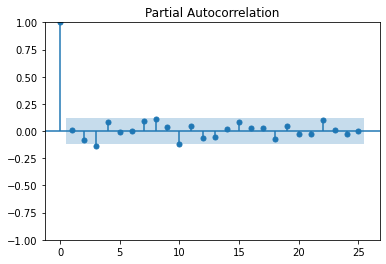

In [77]:
#주가 데이터는 대부분 non-stationary하므로, 바로 log변환 후, 1차 차분을 진행하였다.
ts_log = np.log(ts)
log_diff_1 = ts_log.diff(periods=1).iloc[1:]
log_diff_1 = log_diff_1.dropna()

timeseries_is_stationary(log_diff_1)

__확인 결과 log변환 후, 1차 차분한 데이터는 stationary 하다.__

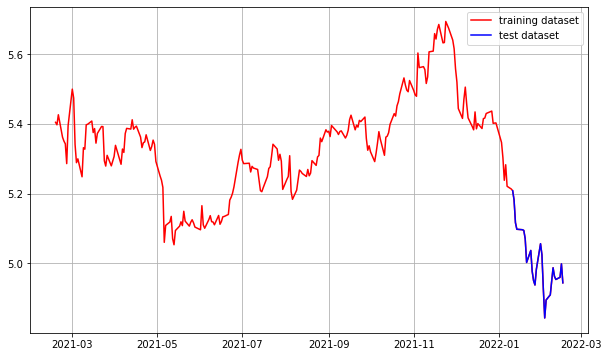

In [78]:
#학습데이터, 테스트 데이터 생성
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)


#train_data 를 출력해야 하지만, 끊겨서 보이는걸 방지하기 위해 ts_log를 출력
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label = 'test dataset')
plt.legend()

In [79]:
#estimate parameters
from pmdarima.arima import auto_arima
model = auto_arima(train_data        # 데이터
                      , d = 1            # 차분 차수
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3   
                      , m = 1       
                      , seasonal = False 
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-851.931, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-850.064, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-850.086, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-853.812, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-849.065, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.287 seconds


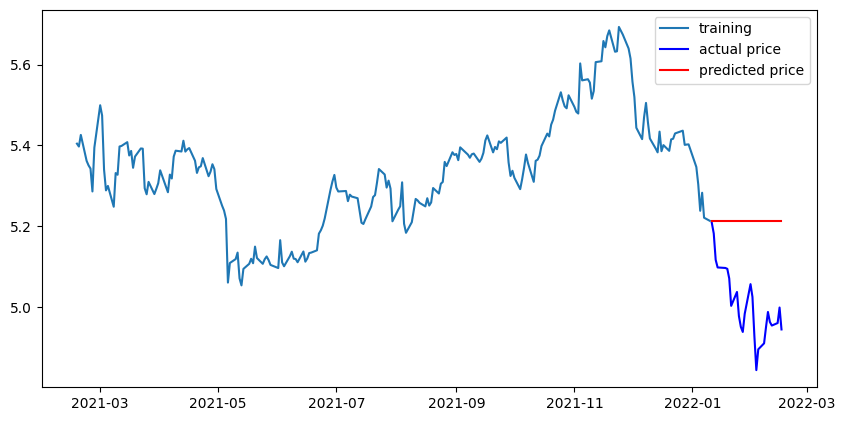

In [80]:
#Test
#위에서 얻은 parameters를 가지고 ARIMA모델에 적용
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc = np.array(fc)
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과


# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [81]:
#모델 평가
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1313.191219962375
MAE:  33.724237846153855
RMSE:  36.2379803515921
MAPE: 23.40%


### (2) 티커명: ULTA (1년간 일일 종가)

In [82]:
# 전처리 
path = os.getenv('HOME') + '/aiffel/exploration/ULTA.csv'
data = pd.read_csv(path, index_col='Date', parse_dates=True)
ts = data['Close']

ts.head()

Date
2021-02-17    324.549988
2021-02-18    318.970001
2021-02-19    321.790009
2021-02-22    327.910004
2021-02-23    328.059998
Name: Close, dtype: float64

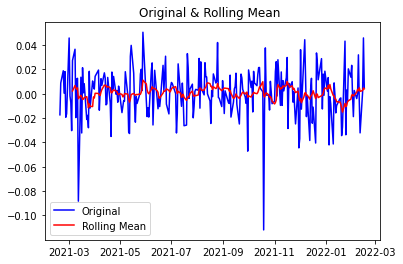

Results of Dickey-Fuller Test:
Test Statistic                -1.606324e+01
p-value                        5.609178e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


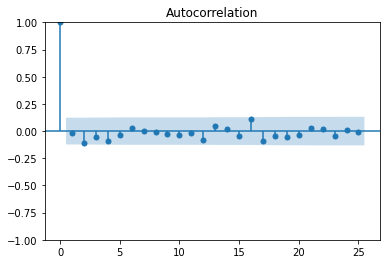

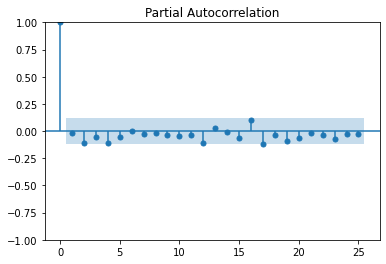

In [83]:
#주가 데이터는 대부분 non-stationary하므로, 바로 log변환 후, 1차 차분을 진행하였다.
ts_log = np.log(ts)
log_diff_1 = ts_log.diff(periods=1).iloc[1:]
log_diff_1 = log_diff_1.dropna()

timeseries_is_stationary(log_diff_1)

__확인 결과 log변환 후, 1차 차분한 데이터는 stationary 하다.__

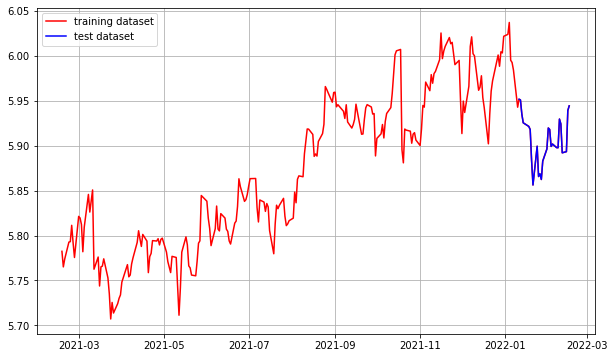

In [84]:
#학습데이터, 테스트 데이터 생성
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)


#train_data 를 출력해야 하지만, 끊겨서 보이는걸 방지하기 위해 ts_log를 출력
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label = 'test dataset')
plt.legend()

In [85]:
#etimate parameters
from pmdarima.arima import auto_arima
model = auto_arima(train_data        # 데이터
                      , d = 1            # 차분 차수
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3   
                      , m = 1       
                      , seasonal = False 
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1116.333, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1114.337, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1114.338, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1118.064, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1118.203, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1123.637, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1114.373, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1121.152, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1120.992, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1124.346, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1115.253, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1120.074, Time=0.70 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1115.185, Time=0.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1119.369, Time=0.95 sec
 ARIMA(1,1,2)(0,0,0

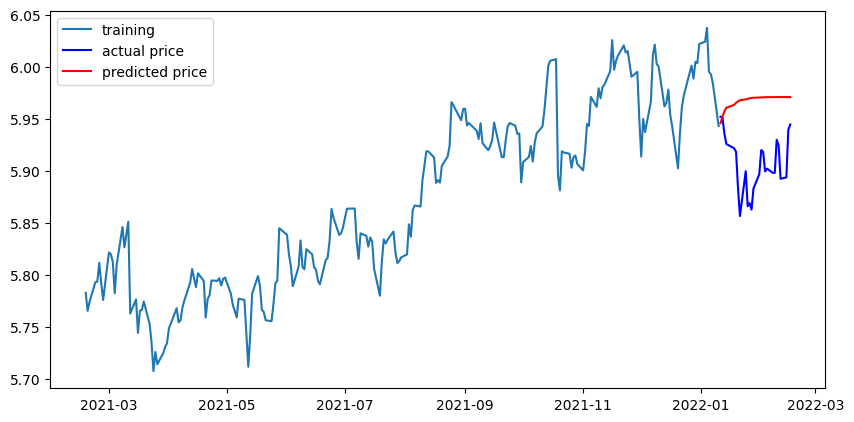

In [86]:
#Test
#위에서 얻은 parameters를 가지고 ARIMA모델에 적용
model = ARIMA(train_data, order=(1, 1, 2))  
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc = np.array(fc)
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과


# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [87]:
#모델 평가
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  643.4765816260843
MAE:  22.888924738358792
RMSE:  25.366840197905695
MAPE: 6.31%


### (3) 티커명: AAPL(1년 기준 종가)

In [88]:
# 전처리 
path = os.getenv('HOME') + '/aiffel/exploration/AAPL.csv'
data = pd.read_csv(path, index_col='Date', parse_dates=True)
ts = data['Close']

ts.head()

Date
2021-02-17    130.839996
2021-02-18    129.710007
2021-02-19    129.869995
2021-02-22    126.000000
2021-02-23    125.860001
Name: Close, dtype: float64

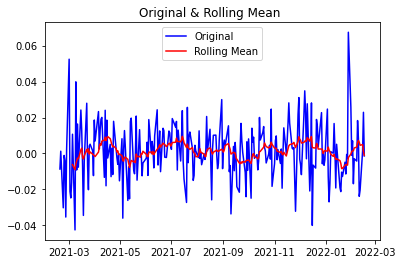

Results of Dickey-Fuller Test:
Test Statistic                -1.613159e+01
p-value                        4.778989e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


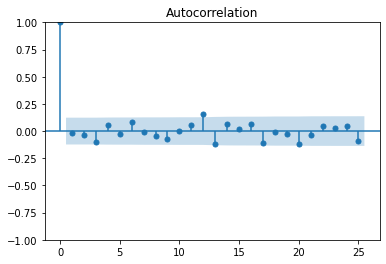

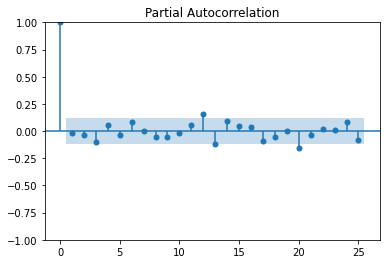

In [89]:
#주가 데이터는 대부분 non-stationary하므로, 바로 log변환 후, 1차 차분을 진행하였다.
ts_log = np.log(ts)
log_diff_1 = ts_log.diff(periods=1).iloc[1:]
log_diff_1 = log_diff_1.dropna()

timeseries_is_stationary(log_diff_1)

__확인 결과 log변환 후, 1차 차분한 데이터는 stationary 하다.__

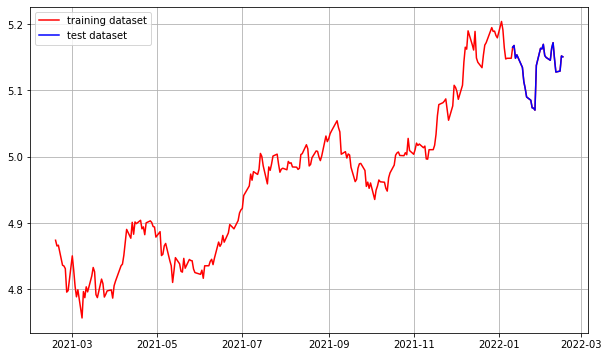

In [90]:
#학습데이터, 테스트 데이터 생성
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)


#train_data 를 출력해야 하지만, 끊겨서 보이는걸 방지하기 위해 ts_log를 출력
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label = 'test dataset')
plt.legend()

In [91]:
#etimate parameters
from pmdarima.arima import auto_arima
model = auto_arima(train_data        # 데이터
                      , d = 1            # 차분 차수
                      , start_p = 0 
                      , max_p = 3   
                      , start_q = 0 
                      , max_q = 3   
                      , m = 1       
                      , seasonal = False 
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1253.150, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1252.285, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1252.398, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1253.712, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1250.336, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.324 seconds


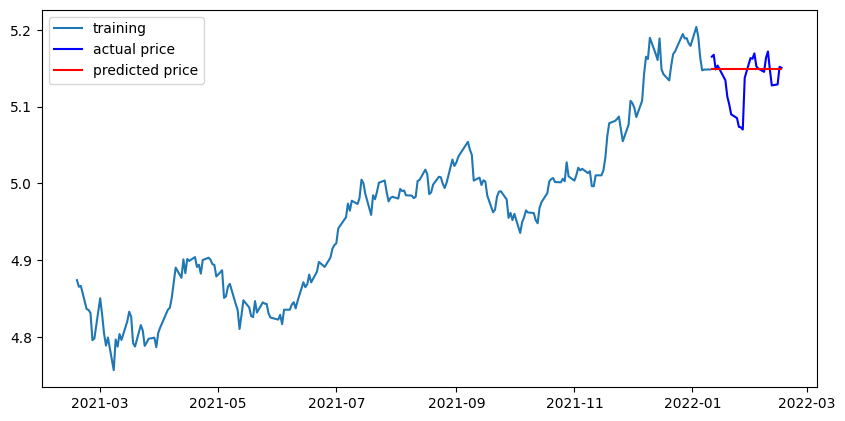

In [92]:
#Test
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc = np.array(fc)
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과


# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


In [93]:
# 모델 평가
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  34.010506200787106
MAE:  4.151922923076906
RMSE:  5.8318527245453575
MAPE: 2.51%


## 회고

* ### 새롭게 알게된 점
    * 시계열 데이터의 특성
    * ARIMA
    * p-value




* ### 결론 
    * 대부분의 예측 모델이 뚜렷한 경향없이 ARIMA(0,1,0) 따르는것을 확인할 수 있었다. ARIAMA(0,1,0)모델을 따르다보니 자연스럽게 예측 plot이 train data의 마지막 시점 기준으로 일직선으로 그어졌고, test data기간동안 급락이나 급등을 한 경우에는 MAPE가 굉장히 높게 나오는것을 확인할 수 있었다. 시계열 분석을 통해 만든 모델이지만, 아직 '예측 모델'이라고 말하기에는 단순히 일직선만 그어주는 모델이기 때문에 미래를 예측하기에는 많이 부족한 것 같다.
    
    
    
* ### 느낀 점
   - 이번 노드를 통해 시계열 데이터에 관해 분석법, 안정성, 특성, 모델 등에 대해 자세히 알 수 있었다. 전에 학교에서 LSTM을 이용하여 주가를 예측하는 프로젝트를 진행해본 경험이 있었는데, 그때는 시계열에 관해 아무것도 모르고 무작정 LSTM에 넣고 모델을 돌렸었던 기억이 있다. 그때는 시계열 데이터라고해서 일반 텍스트 데이터와 뭐가 다른가? 싶었는데 이번 시간을 통해 추세, 계절성 등등을 모두 고려해야한다는 사실을 알게 된 것 같다. 또한, 통계적 근거를 기반으로 한 분석이어서 모델이 추론할때 어떤 식으로, 왜 이런 결과가 도출되었는지 알 수 있어서 굉장히 흥미롭게 노드를 진행할 수 있었다.
    